In [3]:
import cv2
import numpy as np
import pickle
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import nn
from torch import optim
from torchvision import datasets, models, transforms

# Load data and model
class ToTensor(nn.Module):
    def __init__(self):
        super().__init__()
        self.map_to_train_classes = {x.id: x.train_id for x in datasets.Cityscapes.classes}

    def __call__(self, target):
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        mask = torch.zeros_like(target)
        for id, train_id in self.map_to_train_classes.items():
            mask[target == id] = train_id
        return mask

transform = transforms.Compose([transforms.Resize((256, 256), 0),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.2869, 0.3251, 0.2839),
                                                         (0.1761, 0.1810, 0.1777))])
target_transform = transforms.Compose([transforms.Resize((256, 256), 0),
                                           transforms.CenterCrop(224),
                                           ToTensor()])
train_data = datasets.Cityscapes('./data/cityscapes', split='train',
                                    mode='coarse',
                                    target_type='semantic',
                                    transform=transform,
                                    target_transform=target_transform)

model = torch.load('Adam.pt')
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [27]:
from PIL import Image

i = 300
im = Image.open(train_data.images[i])
im = transforms.Resize((256, 256), 0)(im)
im = transforms.CenterCrop(224)(im)

id_to_color = {x.train_id: torch.tensor(x.color) for x in datasets.Cityscapes.classes if not x.ignore_in_eval}
id_to_color[20] = torch.tensor([0, 0, 0])
x = train_data[i][0].unsqueeze(0).cuda()
y = train_data[i][1]
# Predict segmentation
with torch.no_grad():
    y_pred = model(x)['out'].argmax(1).cpu()

torch.Size([1, 224, 224])

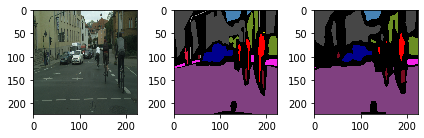

In [28]:
# Plot image, ground truth, predicted
y_im = torch.zeros(3, 224, 224).type(torch.long)
y_pred_im = torch.zeros(3, 224, 224).type(torch.long)

for id, color in id_to_color.items():
    y_pred_im[0, :, :] = torch.where(y_pred[0, :, :] == id, color[0], y_pred_im[0, :, :])
    y_pred_im[1, :, :] = torch.where(y_pred[0, :, :] == id, color[1], y_pred_im[1, :, :])
    y_pred_im[2, :, :] = torch.where(y_pred[0, :, :] == id, color[2], y_pred_im[2, :, :])
    y_im[0, :, :] = torch.where(y == id, color[0], y_im[0, :, :])
    y_im[1, :, :] = torch.where(y == id, color[1], y_im[1, :, :])
    y_im[2, :, :] = torch.where(y == id, color[2], y_im[2, :, :])

x = x.squeeze().permute(1, 2, 0).cpu()
y_pred_im = y_pred_im.permute(1, 2, 0)
y_im = y_im.permute(1, 2, 0)

f, axarr = plt.subplots(1, 3)
axarr[0].imshow(im, label='Image')
axarr[1].imshow(y_im, label='Train')
axarr[2].imshow(y_pred_im, label='Predicted')
plt.tight_layout()
plt.savefig('ex' + str(i) + '.png', dpi=300)